## Интеллектуальный анализ данных – весна 2023
## Домашнее задание 4: kNN. Линейные модели. Работа с признаками

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

### Задание 1:  Визуализация решающих поверхностей в kNN.

В этом задании мы изобразим решающую поверхность для классификатора kNN, чтобы наглядно увидеть, как классификатор принимает решения для новых объектов. Для простоты будем работать со встроенным в `sklearn` набором данных `wine`, содержащим информацию о характеристиках трёх видов вина. Описание набора можно найти [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine) и [здесь](https://rdrr.io/cran/rattle.data/man/wine.html). 

Загрузим набор данных и сохраним информацию о признаках в переменную `X`, а о зависимой переменной – в переменную `y`.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED) 

In [4]:
from sklearn.datasets import load_wine

data = load_wine()
X = pd.DataFrame(data['data'], columns = data['feature_names'])
y = data['target']
X.head(8)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0
7,14.06,2.15,2.61,17.6,121.0,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295.0


In [5]:
X.shape, y.shape

((178, 13), (178,))

**Задача 1.1 (0.5 балла)** Есть ли в наборе данных пропущенные значения? Если да, то удалите их. Есть ли в наборе данных категориальные переменные? Если да, то закодируйте их при помощи OneHot-кодирования.

Количество пропущенных значений:

In [6]:
X.isna().sum()

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
dtype: int64

Количество категориальных переменных:

In [7]:
X.dtypes.value_counts()

float64    13
dtype: int64

**Задача 1.2 (0.5 балла)** Используя функцию `train_test_split()`, разделите выборку на тренировочную и тестовую, и долю тестовой выборки задайте равной 0.3. Так как разбиение осуществляется случайным образом, не забудьте зафиксировать `np.random.seed()` для воспроизводимости результатов.

In [8]:
TEST_SIZE = 0.3

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED)

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((124, 13), (54, 13), (124,), (54,))

**Задача 1.3 (1 балл)** На тренировочной выборке обучите шесть классификаторов kNN, отличающихся только числом соседей. Для первого классификатора число соседей поставьте равным 1, для второго - 3, для третьего – 5, для четвертого – 10, для пятого – 15 и для шестого – 25 (обратите внимание на параметр `n_neighbours` класса `KNeighborsClassifier`). Для обучения используйте только два признака: `alcohol` и `magnesium` – и евклидово расстояние. Не забудьте масштабировать признаки, например, при помощи модуля `StandardScaler`.

Выведите долю правильных ответов на тренировочной и тестовой выборках для каждого классификатора.

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

Оставляем только признаки alcohol и magnesium:

In [12]:
X_train = X_train[['alcohol', 'magnesium']].values
X_test = X_test[['alcohol', 'magnesium']].values

Масштабируем признаки:

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Обучаем KNN:

In [14]:
k_values = [1, 3, 5, 10, 15, 25]

print('NN', 'Train', 'Test')

classifiers = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    classifiers += [knn]
    
    train_predictions = knn.predict(X_train_scaled)
    train_accuracy = accuracy_score(y_train, train_predictions)
    
    test_predictions = knn.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, test_predictions)
    
    
    print(k, round(train_accuracy, 2), round(test_accuracy, 2))
    

NN Train Test
1 0.99 0.67
3 0.84 0.65
5 0.81 0.69
10 0.81 0.7
15 0.78 0.69
25 0.73 0.69


**Задача 1.4 (0 баллов)** Установите библиотеку `mlxtend` командой ниже. Библиотеку также можно установить из терминала при помощи `pip` или `conda`, как указано [здесь](http://rasbt.github.io/mlxtend/installation/). 

In [15]:
# !pip install mlxtend

Если всё прошло успешно, то в выводе команды выше вы увидите сообщение вроде "successfully installed", а следующая ячейка выполнится без ошибок.

In [16]:
import mlxtend

**Задача 1.5 (1 балл)** Библиотека `mlxtend` позволяет достаточно просто визуализировать решающие поверхности обученных классификаторов. Изучите [документацию](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/) библиотеки и найдите, как можно построить несколько графиков решающих поверхностей на сетке (decision regions grid). Постройте такую сетку графиков для обученных выше классификаторов.

**Подсказки:**
1. Вы можете использовать готовый код, приведённый в документации, и адаптировать его для нашего случая.
2. Вам могут понадобиться дополнительные библиотеки, которые используются в примере из документации.
3. Обратите внимание на то, как нужно изменить параметры `gridspec.GridSpec()` и `itertools.product()` для нашего числа классификаторов. 
4. В функции `plot_decision_region()` используйте `y_train` и нужные столбцы из `X_train`. Возможно, их придётся перевести в формат массива `numpy`.
5. Если в задаче 1.3 вы сохраните обученные классификаторы в список, то не будет необходимости обучать их заново. 
6. Построение графика может занять некоторое время – придётся немного подождать!

In [17]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
from tqdm import tqdm

100%|█████████████████████████████████████████████| 6/6 [02:04<00:00, 20.80s/it]


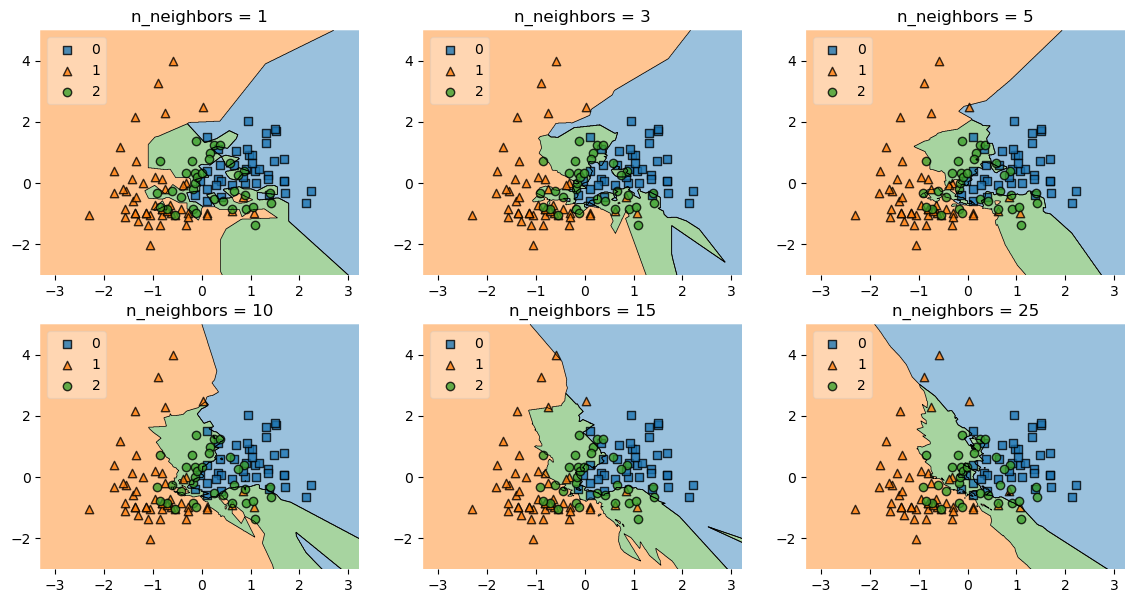

In [18]:
gs = gridspec.GridSpec(2, 3)

fig = plt.figure(figsize=(14, 7))

for clf, grd in tqdm(list(zip(classifiers,
                         itertools.product(*[[0, 1], [0, 1, 2]])))):
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_train_scaled, y=y_train, clf=clf, legend=2)
    plt.title(f'n_neighbors = {clf.n_neighbors}')

plt.show()

**Задача 1.6 (0.5 балла)** Прокомментируйте результаты, полученные в задачах 1.3 и 1.5. Какое число соседей оптимально использовать для обучения классификатора? Поясните ваш выбор при помощи описания геометрии данных и получаемой решающей поверхности.

В задаче 1.5 мы видим, что при k = 1 модель переобучается: появляются области под отдельные объекты, из-за которых падает качество на тесте. При увеличении значения k наши поверхности начинают сглаживаться и уже при k = 10-15 появляется довольно адеватное разделение. Кроме улучшения ситуации на картинках в задаче 1.5, мы видим увеличение значения accuracy на тесте в задаче 1.3.

### Задание 2. KNN своими руками. 2 Балла

В данном задании мы попробуем реализовать алгоритм KNN своими руками. В данном случае мы попробуем сделать KNN для классификации.

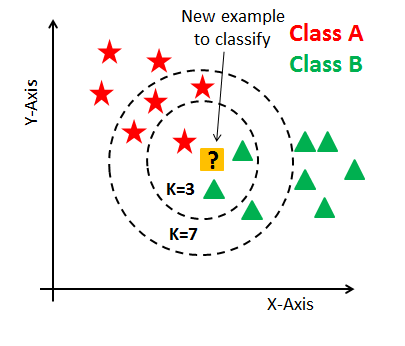

In [19]:
def euclidean_distance(x1: np.array, x2: np.array):
    return np.sqrt(np.sum(np.square(x1 - x2)))

In [20]:
import numpy as np
from collections import Counter 

class KNN:
    def __init__(self, k:int):
        self.k = k
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        
    def __predict_on_one_object(self, x):
        # Вычисляем расстояние от нашего объекта до каждого объекта из обучающей выборки.        
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        # Вычисляем индексы k ближайших элементов к объекту x.         
        k_indices = np.argsort(distances)[:self.k]
        # Среди k ближайших объектов берем тот класс, который встречается чаще всего.         
        prediction = Counter(self.y_train[k_indices]).most_common(1)[0][0]
        return prediction
    
    def predict(self, X):
        return [self.__predict_on_one_object(x) for x in X]

In [21]:
# Не меняйте файл!
def test_knn(KNN):
    knn = KNN(k=1)
    X_train =  np.array([[1, 1], [2, 2]])
    y_train =  np.array([0, 1])
    X_test =  np.array([[1.5, 1.5]])
    knn.fit(X_train, y_train)
    assert knn.predict(X_test) == [0]

    knn = KNN(k=3)
    X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
    y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
    X_test = np.array([[9.5, 9.5]])
    knn.fit(X_train, y_train)
    assert knn.predict(X_test) == [1]

    knn = KNN(k=3)
    X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
    y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
    X_test = np.array([[5.5, 5.5]])
    knn.fit(X_train, y_train)
    assert knn.predict(X_test) == [1]

    knn = KNN(k=3)
    X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
    y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
    X_test = np.array([[15, 15]])
    knn.fit(X_train, y_train)
    assert knn.predict(X_test) == [1]

    knn = KNN(k=3)
    X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
    y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
    X_test = np.array([[5, 5], [2, 2]])
    knn.fit(X_train, y_train)
    assert knn.predict(X_test) == [1, 0]

In [22]:
# Если тесты эти пройдены, то все верно!
test_knn(KNN)

### Задание 3: Линейная регрессия.

В этом задании мы рассмотрим различные аспекты построения линейной модели. Мы будем работать с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds).

Carat --> weight of the diamond (0.2--5.01)

Cut --> Describe cut quality of the diamond. Quality in increasing order Fair, Good, Very Good, Premium, Ideal

Color --> Color of the diamond, with D being the best and J the worst

Clarity --> How obvious inclusions are within the diamond:(in order from best to worst, FL = flawless, I3= level 3 inclusions) FL,IF, VVS1, VVS2, VS1, VS2, SI1, SI2, I1, I2, I3

Depth --> The height of a diamond, measured from the culet to the table, divided by its average girdle diameter

Table --> The width of the diamond's table expressed as a percentage of its average diameter

Price --> the price of the diamond

x --> length mm

y --> width mm

z --> depth mm

In [114]:
df = pd.read_csv('diamonds.csv')
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [115]:
df.shape

(53940, 11)

Мы будем решать задачу предсказания цены бриллианта `price` в зависимости от его характеристик.

**Задача 3.1 (0.1 балла)** Есть ли в наборе данных пропущенные значения? Если да, удалите их. 

In [116]:
df.isna().sum()

Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
z             0
dtype: int64

**Задача 3.2 (0.1 балла)** Есть ли в наборе данных бессмысленные столбцы (признаки, не несущие дополнительной информации)? Если да, то удалите их.

In [117]:
df.drop(columns=['Unnamed: 0'], inplace=True)

**Задача 3.3 (0.1 балла)** Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной, а потому перед выбором переменных для включения в модель имеет смысл проверить, насколько эта связь выполняется. Для следующих пунктов нам также потребуются выборочные корреляции между признаками. Выведите матрицу выборочных корреляций между всеми вещественными признаками и целевой переменной (то есть в этой матрице будет $k+1$ строка, где $k$ – количество вещественных признаков).

Какие вещественные признаки коррелируют с целевой переменной больше всего?

Практически все вещественные признаки, кроме **depth** и **table** имеют очень высокую корреляцию с ценой.

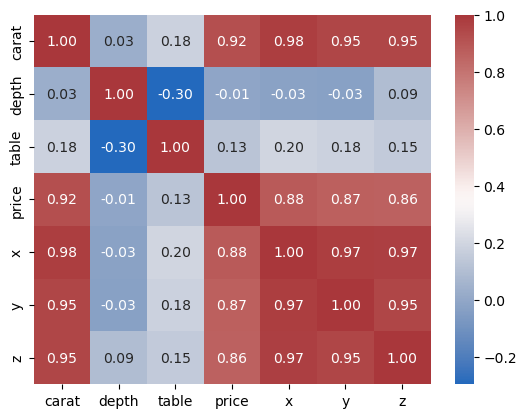

In [118]:
sns.heatmap(df.corr(numeric_only=True), cmap="vlag", annot=True, fmt="0.2f");

**Задача 3.4 (0.1 балла)** Так как линейная модель складывает значения признаков с некоторыми весами, нам нужно аккуратно обработать категориальные признаки. Закодируйте категориальные переменные при помощи OneHot-кодирования.

In [119]:
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded.head()

,carat,depth,table,price,x,y,z,cut_Good,cut_Ideal,cut_Premium,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0,0,1,...,0,1,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,1,0,0,...,0,0,1,0,0,1,0,0,0,0


**Задача 3.5 (0.2 балла)** Разделите выборку на тренировочную и тестовую. Долю тестовой выборки укажите равной 0.3.

In [120]:
TEST_SIZE = 0.3

In [121]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop(columns=['price']),
                                                    df_encoded['price'].values,
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_SEED)

In [122]:
X_train.head()

,carat,depth,table,x,y,z,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
19497,1.21,61.3,57.0,6.92,6.87,4.23,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
31229,0.31,62.0,56.0,4.38,4.36,2.71,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
22311,1.21,62.4,57.0,6.75,6.83,4.24,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
278,0.81,62.6,55.0,5.92,5.96,3.72,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
6646,0.79,61.7,56.0,5.94,5.95,3.67,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1


In [123]:
y_train

array([ 8131,   756, 10351, ...,  1014,  2871,  6320])

**Задача 3.6 (0.3 балла)** Зачастую при использовании линейных моделей вещественные признаки масштабируются. При этом оценки коэффициентов теряют прямую статистическую интерпретацию ("при увеличении $X_1$ на 1, $y$ увеличивается на $w_1$"), но приобретают свойства, полезные в задачах машинного обучения. В этой задаче масштабируйте вещественные признаки тренировочной и тестовой выборок при помощи модуля `StandardScaler`.

In [124]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Задача 3.7 (0.2 балла)** Оцените линейную регрессию на тренировочной выборке. Выведите среднеквадратичную ошибку на тренировочной и тестовой выборках.

In [125]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [127]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
train_predictions = lr.predict(X_train_scaled)
test_predictions = lr.predict(X_test_scaled)
print(f"Train MSE: {mean_squared_error(train_predictions, y_train)}")
print(f"Test MSE: {mean_squared_error(test_predictions, y_test)}")

Train MSE: 1290541.9147450614
Test MSE: 1244765.4357158693


**Задача 3.8 (0.2 балла)** Изучите документацию модуля `LinearRegression` и выведите полученные оценки коэффициентов. Назовите вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных.

In [128]:
coef_df = pd.DataFrame({'feature': X_train.columns, 'coef': lr.coef_}).sort_values(by=['coef'])
coef_df

,feature,coef
3,x,-1100.418850
15,color_J,-529.449216
14,color_I,-442.783567
13,color_H,-362.002300
12,color_G,-202.863564
11,color_F,-104.560993
1,depth,-90.173817
10,color_E,-83.640021
2,table,-60.332280
5,z,-34.258945


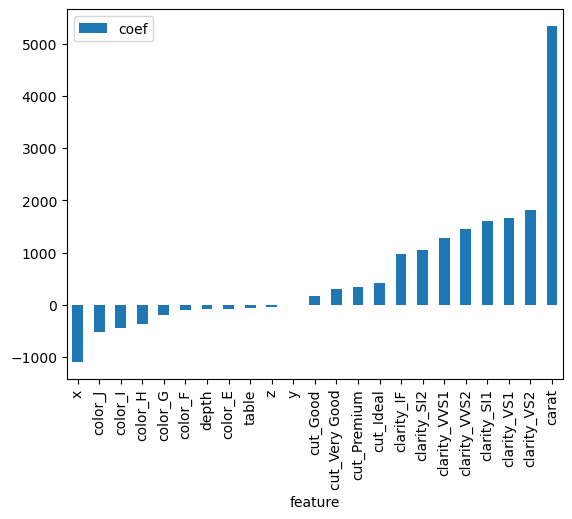

In [129]:
coef_df.plot.bar(x='feature', y='coef', rot=0)
plt.xticks(rotation=90);

**Задача 3.9 (0.4 балла)** Как можно заметить из анализа корреляционной матрицы в задаче 3.3, между некоторыми признаками имеется сильная корреляция, что может быть индикатором проблемы *мультиколлинеарности*. Различия в порядке коэффициентов, выявленные в предыдущей задаче также намекают на её присутствие. Как известно, для решения этой проблемы можно либо исключить некоторые признаки из модели, либо использовать регуляризацию. Мы воспользуемся вторым вариантом. 

Вспомним, что смысл регуляризации заключается в том, чтобы изменить функцию потерь так, чтобы устранить проблемы, появляющиеся из-за мультиколлинеарности. При L1-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\sum_{i=1}^k|w_i|
$$

Такая модель называется Lasso-регрессией.

При L2-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \frac{1}{2}\alpha\|w\|^2
$$

Такая модель называется Ridge-регрессией. 

Обучите Lasso-регрессию и Ridge-регрессию, уставновив гиперпараметр регуляризации равным 10. Для этого используйте модули `Lasso` и `Ridge` из `sklearn`. Сильно ли уменьшились веса? Сделайте вывод о том, насколько сильно проблема мультиколлинеарности проявлялась в изначальной регрессии.

In [130]:
REG_PARAM = 10

In [131]:
from sklearn.linear_model import Lasso, Ridge

Train MSE for lasso: 1351084.3270356874
Test MSE for lasso: 1293860.3256531465


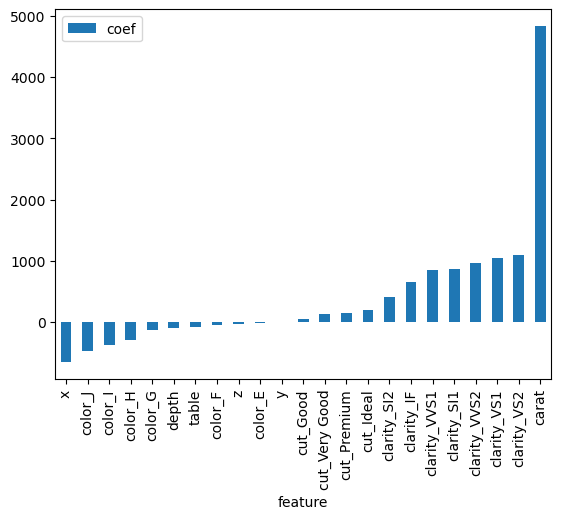

In [132]:
lr_lasso = Lasso(alpha=REG_PARAM, random_state=RANDOM_SEED)
lr_lasso.fit(X_train_scaled, y_train)
train_predictions = lr_lasso.predict(X_train_scaled)
test_predictions = lr_lasso.predict(X_test_scaled)
print(f"Train MSE for lasso: {mean_squared_error(train_predictions, y_train)}")
print(f"Test MSE for lasso: {mean_squared_error(test_predictions, y_test)}")
coef_df = pd.DataFrame({'feature': X_train.columns, 'coef': lr_lasso.coef_}).sort_values(by=['coef'])
coef_df.plot.bar(x='feature', y='coef', rot=0)
plt.xticks(rotation=90);

Train MSE for ridge: 1290671.498720799
Test MSE for ridge: 1244573.4008026142


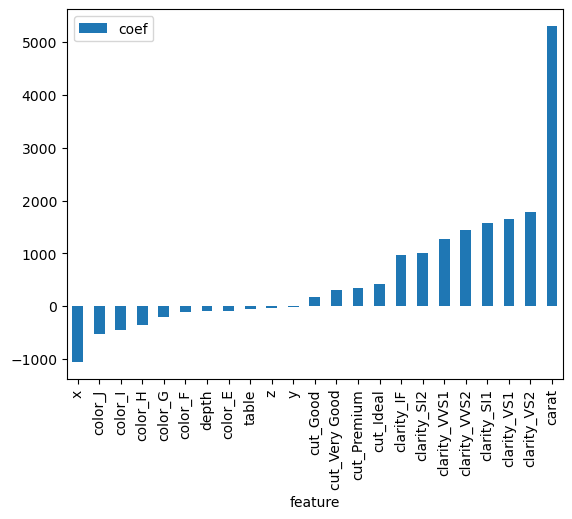

In [133]:
lr_ridge = Ridge(alpha=REG_PARAM, random_state=RANDOM_SEED)
lr_ridge.fit(X_train_scaled, y_train)
train_predictions = lr_ridge.predict(X_train_scaled)
test_predictions = lr_ridge.predict(X_test_scaled)
print(f"Train MSE for ridge: {mean_squared_error(train_predictions, y_train)}")
print(f"Test MSE for ridge: {mean_squared_error(test_predictions, y_test)}")
coef_df = pd.DataFrame({'feature': X_train.columns, 'coef': lr_ridge.coef_}).sort_values(by=['coef'])
coef_df.plot.bar(x='feature', y='coef', rot=0)
plt.xticks(rotation=90);

**Задача 3.10 (0.4 балла)** Как обсуждалось на семинарах, Lasso-регрессию можно использовать для отбора наиболее информативных признаков. Для следующих значений параметра регуляриазции $\alpha$: 0.1, 1, 10, 100, 200 –  обучите Lasso- и Ridge-регрессии и постройте график измненения евклидовой нормы весов (`np.linalg.norm()` от вектора оценок коэффициентов) в зависимости от параметра $\alpha$. Как известно, норма является численной характеристикой величины вектора, а потому по норме можно судить о том, насколько большие элементы содержит вектор оценок коэффициентов. 

In [134]:
reg_params = [0.1, 1, 10, 100, 200]

In [136]:
euclidean_norm_of_weights_lasso = []
euclidean_norm_of_weights_ridge = []

for reg_param in reg_params:
    lr_lasso = Lasso(reg_param, random_state=RANDOM_SEED)
    lr_lasso.fit(X_train_scaled, y_train)
    euclidean_norm_of_weights_lasso += [np.linalg.norm(lr_lasso.coef_)]
    
    
    lr_ridge = Ridge(reg_param, random_state=RANDOM_SEED)
    lr_ridge.fit(X_train_scaled, y_train)
    euclidean_norm_of_weights_ridge += [np.linalg.norm(lr_ridge.coef_)]

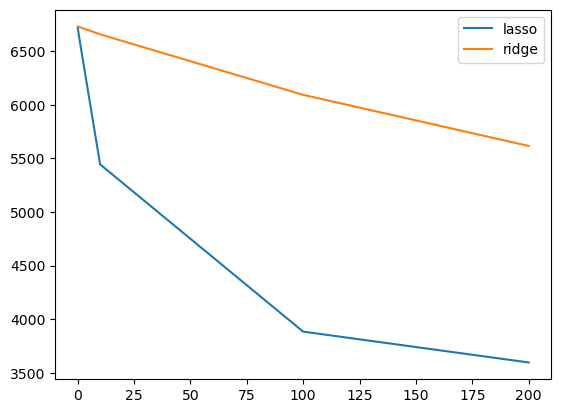

In [137]:
plt.plot(reg_params, euclidean_norm_of_weights_lasso, label = "lasso") 
plt.plot(reg_params, euclidean_norm_of_weights_ridge, label = "ridge") 
plt.legend() 
plt.show()

**Задача 3.11 (0.5 балла)** 
В зависимости от значения параметра $\alpha$ в Lasso-регрессии зануляются разные оценки коэффициентов. Оптимальное значение $\alpha$ можно подобрать, например, при помощи кросс-валидации по тренировочной выборке. 

Для проведения кросс-валидации можно использовать модуль `LassoCV`. Этот модуль принимает список значений $\alpha$ (параметр `alphas`) и при обучении проводит кросс-валидацию для каждого значения из этого списка, сохраняя MSE на каждом участке кросс-валидации (количество участков – параметр `cv`) в матрицу ошибок (то есть итоговая матрица будет иметь размер `len(alphas)` $\times$ `cv`). После обучения модели матрицу ошибок можно получить, обратившись к атрибуту `.mse_path_`. 

Заметим, что модель может использовать $\alpha$ не в том порядке, в котором вы подаёте их в функцию: для определения порядка используйте атрибут `.alphas_` Установите количество участков для кросс-валидации (параметр `cv`) равным 5.

Усредните ошибки для каждого значения $\alpha$ (то есть по строкам матрицы ошибок) и выберите то значение, которое даёт наибольшее качество. 

In [138]:
from sklearn.linear_model import LassoCV

In [139]:
CV = 5

In [140]:
lasso_cv = LassoCV(cv=CV, random_state=RANDOM_SEED, alphas=reg_params, tol=0.01)
lasso_cv.alphas_ = reg_params
lasso_cv.fit(X_train_scaled, y_train)

LassoCV(alphas=[0.1, 1, 10, 100, 200], cv=5, random_state=42, tol=0.01)

In [141]:
error_matrix = pd.DataFrame(lasso_cv.mse_path_, columns =[f'cv_{i+1}' for i in range(CV)])
error_matrix['mean_error'] = error_matrix.mean(axis=1)
error_matrix.insert(0, 'alpha', reg_params)
error_matrix = error_matrix.sort_values('mean_error')
error_matrix

,alpha,cv_1,cv_2,cv_3,cv_4,cv_5,mean_error
3,100.0,1.335257e+06,1.294190e+06,1.337382e+06,1.257247e+06,1.248143e+06,1.294444e+06
4,200.0,1.333862e+06,1.293076e+06,1.344953e+06,1.258695e+06,1.245430e+06,1.295203e+06
2,10.0,1.438840e+06,1.387601e+06,1.440235e+06,1.327566e+06,1.348158e+06,1.388480e+06
1,1.0,1.879966e+06,1.820155e+06,1.847019e+06,1.731900e+06,1.756828e+06,1.807174e+06
0,0.1,2.252701e+06,2.203935e+06,2.196507e+06,2.114353e+06,2.137210e+06,2.180941e+06


In [142]:
best_alpha = error_matrix.alpha.tolist()[0]
best_alpha

100.0

**Задача 3.12 (0.5 балла)** Обучите итоговую Lasso-регрессию с выбранным параметром $\alpha$ на тренировочной выборке. Выведите полученные коэффициенты и прокомментируйте, какие признаки оказались неинформативными, а какие – наиболее информативными. Приведите возможное смысловое объяснение этого результата.

In [143]:
lr_lasso_final = Lasso(alpha=best_alpha, random_state=RANDOM_SEED)
lr_lasso_final.fit(X_train_scaled, y_train)

Lasso(alpha=100.0, random_state=42)

Неинформативными признаками по мнению Lasso являются те, которые после обучения имеют коэффициенты равные нулю. Внизу мы видим список зануленных признаков:

In [144]:
X_train.columns[np.where(lr_lasso_final.coef_ == 0)[0]].tolist()

['table',
 'x',
 'y',
 'z',
 'cut_Good',
 'cut_Premium',
 'cut_Very Good',
 'color_E',
 'color_F',
 'color_G',
 'clarity_VS2']

Наиболее информативным является признак carat, который описывает вес алмаза. Такие признаки, как, например, длина, ширина и высота алмаза никак не влияют на его стоимость.

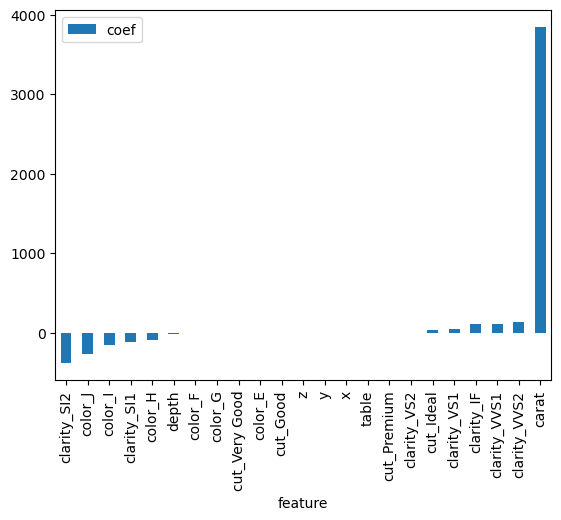

In [145]:
coef_df = pd.DataFrame({'feature': X_train.columns, 'coef': lr_lasso_final.coef_}).sort_values(by=['coef'])
coef_df.plot.bar(x='feature', y='coef', rot=0)
plt.xticks(rotation=90);

**Задача 3.13 (0.4 балла)** Сделайте предсказания обученной Lasso-регрессии на тестовой выборке и сравните среднеквадратичную ошибку с ошибкой обычной линейной регрессии из задачи 3.7.

In [146]:
test_prediction = lr_lasso_final.predict(X_test_scaled)
print(f"Lasso MSE on test: {mean_squared_error(y_test, test_prediction)}")

Lasso MSE on test: 1740228.6972732404
